In [2]:
#NAME: KARL MICHAEL JACINTO
#DATE: 23/07/2021

#THIS CODE STATISTICALLY TESTS THE IMPACT OF A CHANGED STORE LAYOUT

In [58]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

In [59]:
transactions_customers = pd.read_csv("transactions_customers.csv", 
                                     index_col = 0)

In [60]:
transactions_customers.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,Weight,Chip Variety,Brand,LIFESTAGE,PREMIUM_CUSTOMER,Price
0,43390,1,1000,1,5,2,6.0,175,Natural Chip Company Sea Salt,Natural Chip Company,YOUNG SINGLES/COUPLES,Premium,3.00
1,43599,1,1307,348,66,3,6.3,175,CCs Nacho Cheese,CCs,MIDAGE SINGLES/COUPLES,Budget,2.10
2,43414,1,1307,346,96,2,3.8,160,Woolworths Stacked Chips Original,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90
3,43533,1,1307,347,54,1,2.1,175,CCs Original,CCs,MIDAGE SINGLES/COUPLES,Budget,2.10
4,43605,1,1343,383,61,2,2.9,170,Smiths Crinkle Cut Chicken,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45


In [61]:
#Converts Excel serial number to date
def serial_to_date(date):
    start = datetime.datetime(1899, 12, 30) #Note 30th instead of 31st
    delta = datetime.timedelta(days = date)
    return start + delta

transactions_customers["DATE"] = transactions_customers["DATE"].apply(serial_to_date)

In [62]:
#Gets the month from the date

transactions_customers["Year_month"] = transactions_customers["DATE"].dt.to_period("M")

In [63]:
#Gets total sales, customers, and transactions
total_sales = transactions_customers.groupby(["STORE_NBR", 
                                              "Year_month"]).sum()["TOT_SALES"]

total_cust = transactions_customers.groupby(["STORE_NBR", 
                                             "Year_month"])["LYLTY_CARD_NBR"].nunique()

total_trans = transactions_customers.groupby(["STORE_NBR", 
                                              "Year_month"])["TXN_ID"].nunique()

In [64]:
#Combines total sales and total customers figures together
total_sales_cust = pd.merge(total_sales, 
                            total_cust, 
                            left_index = True, 
                            right_index = True)

In [68]:
#Combines total sales, total customers, and total transactions together
store_level_data = total_sales_cust.merge(total_trans, 
                                          left_index = True, 
                                          right_index = True)

#Calculates transactions per customer
store_level_data["Transactions per customer"] = (store_level_data["TXN_ID"] / 
                                                 store_level_data["LYLTY_CARD_NBR"])

store_level_data = store_level_data.drop("TXN_ID", axis = 1)

store_level_data.columns = ["Total sales", 
                            "Total customers", 
                            "Transactions per customer"]

#Reshapes the data so that metrics and months are the indices
store_level_data = store_level_data.unstack().transpose() 

store_level_data = store_level_data.reset_index()

store_level_data["Year_month"] = store_level_data["Year_month"].astype(str)

In [69]:
#Gets data excluding the trial period
store_level_data_train = store_level_data[~store_level_data["Year_month"].
                                          isin(["2019-02", 
                                                "2019-03", 
                                                "2019-04"])]

#Sets the metric and month as the columns and the store number as the index
store_level_data_train = store_level_data_train.set_index(["level_0", 
                                                           "Year_month"])
store_level_data_train = store_level_data_train.unstack(level = 0).stack(level = 0)
store_level_data_train.index = store_level_data_train.index.swaplevel(0,1)

#Removes stores with no sales during any month
store_level_data_train = store_level_data_train.unstack().dropna() 

In [70]:
#Because the three metrics are of vastly different scales, 
#we need to normalise the data so that larger values 
#do not overly impact the calculation
from sklearn.preprocessing import normalize

store_level_data_train_normalised = pd.DataFrame(normalize(store_level_data_train, 
                                                           axis = 0))
store_level_data_train_normalised.index = store_level_data_train.index
store_level_data_train_normalised.columns = store_level_data_train.columns

In [74]:
test_stores = [77,86,88]

In [75]:
#We will use a k nearest neighbours algorithm 
#to find the nearest store to the test stores
from sklearn.neighbors import NearestNeighbors

In [76]:
#calculates nearest neighbours
nbrs = NearestNeighbors(n_neighbors=2).fit(store_level_data_train_normalised)

distances, indices = nbrs.kneighbors(store_level_data_train_normalised)

#When NAs were removed, this misaligned the index locations with the store numbers. 
#This code rectifies this.
indices_to_stores = dict(zip(list(range(len(indices))),
                             list(store_level_data_train_normalised
                                  .index)))
stores_nn = pd.DataFrame(indices)
stores_nn = stores_nn.replace(indices_to_stores)


stores_nn = stores_nn.set_index(0)

#Converts to dictionary
stores_nn = stores_nn.to_dict("index")

#Takes only test stores
control_store_dict = {key: list(stores_nn[key].values()) 
                      for key in stores_nn if key in test_stores} 

In [77]:
control_store_dict

{77: [233], 86: [155], 88: [237]}

In [78]:
pd.set_option('display.max_columns', None)
store_level_data_train.loc[[77] + control_store_dict[77]] 

level_0    Total customers                                                  \
Year_month         2018-07 2018-08 2018-09 2018-10 2018-11 2018-12 2019-01   
STORE_NBR                                                                    
77                    51.0    47.0    42.0    37.0    41.0    46.0    35.0   
233                   51.0    48.0    42.0    35.0    40.0    47.0    35.0   

level_0                    Total sales                                  \
Year_month 2019-05 2019-06     2018-07 2018-08 2018-09 2018-10 2018-11   
STORE_NBR                                                                
77            55.0    41.0       296.8   255.5   225.2   204.5   245.3   
233           57.0    41.0       290.7   285.9   228.6   185.7   211.6   

level_0                                    Transactions per customer  \
Year_month 2018-12 2019-01 2019-05 2019-06                   2018-07   
STORE_NBR                                                              
77           267.3   204.4   299.3   264.7                  1.078431   
233          279.8   177.5   344.4   221.0                  1.058824   

level_0                                                                 \
Year_month   2018-08   2018-09   2018-10   2018-11   2018-12   2019-01   
STORE_NBR                                                                
77          1.021277  1.047619  1.027027  1.073171  1.043478  1.114286   
233         1.041667  1.071429  1.028571  1.025000  1.063830  1.000000   

level_0                        
Year_month   2019-05  2019-06  
STORE_NBR                      
77          1.018182  1.02439  
233         1.087719  1.00000

<AxesSubplot:title={'center':'Comparison of stores 77 and 233, non-test periods'}, xlabel='Year_month', ylabel='Total sales'>

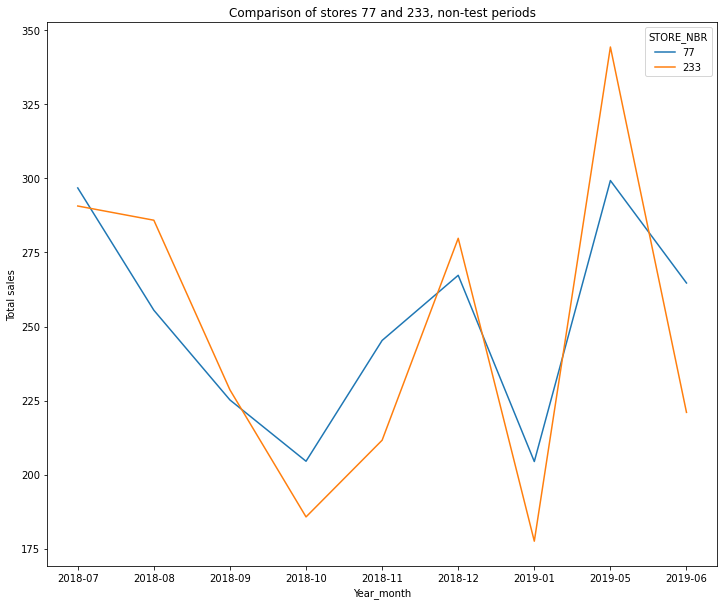

In [79]:
fig, ax = plt.subplots(figsize = (12,10))
store_level_data_train.loc[[77] + 
                           control_store_dict[77]]["Total sales"].transpose().plot(
    ylabel = "Total sales", 
    title = "Comparison of stores 77 and 233, non-test periods",
    ax = ax)

They look quite similar!

<AxesSubplot:title={'center':'Comparison of stores 86 and 155, non-test periods'}, xlabel='Year_month', ylabel='Total sales'>

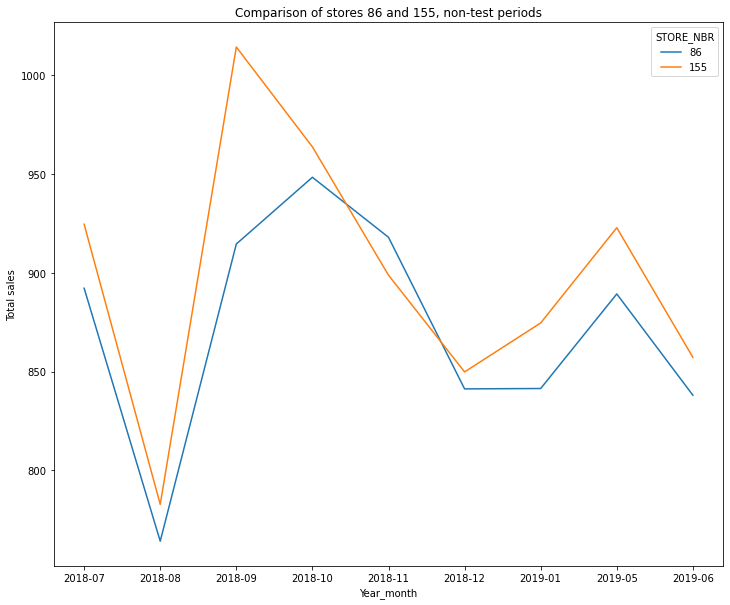

In [80]:
fig, ax = plt.subplots(figsize = (12,10))
store_level_data_train.loc[[86] + 
                           control_store_dict[86]]["Total sales"].transpose().plot(
    ylabel = "Total sales", 
    title = "Comparison of stores 86 and 155, non-test periods",
    ax = ax)

<AxesSubplot:title={'center':'Comparison of stores 88 and 237, non-test periods'}, xlabel='Year_month', ylabel='Total sales'>

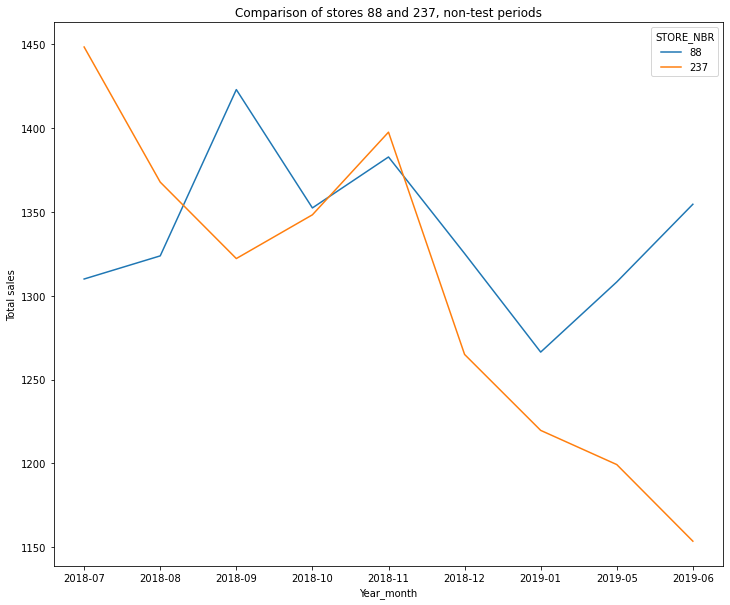

In [81]:
fig, ax = plt.subplots(figsize = (12,10))
store_level_data_train.loc[[88] + 
                           control_store_dict[88]]["Total sales"].transpose().plot(
    ylabel = "Total sales", 
    title = "Comparison of stores 88 and 237, non-test periods",
    ax = ax)

In [82]:
#Gets the store-level data for the testing period
store_level_data_test = store_level_data[
    store_level_data["Year_month"].isin(["2019-02", 
                                         "2019-03", 
                                         "2019-04"])]

store_level_data_test = store_level_data_test.set_index(["level_0", 
                                                         "Year_month"])

store_level_data_test = store_level_data_test.unstack(level = 0).stack(level = 0)

store_level_data_test.index = store_level_data_test.index.swaplevel(0,1)

store_level_data_test = store_level_data_test.unstack().dropna()

In [83]:
#Combines the non-testing and the testing data together
store_level_data_combined = pd.concat([store_level_data_train,
                                       store_level_data_test], 
                                      axis = 1)

store_level_data_combined = store_level_data_combined.reindex(
    sorted(store_level_data_combined.columns), 
    axis=1)

In [84]:
#Combines the non-testing and the testing data together for total sales only. 
#Makes the graphing easier to code
sales_combined = pd.concat([store_level_data_train["Total sales"],
                            store_level_data_test["Total sales"]], 
                           axis = 1)

sales_combined = sales_combined.reindex(sorted(sales_combined.columns), 
                                        axis=1)

<AxesSubplot:xlabel='Year_month', ylabel='Total sales'>

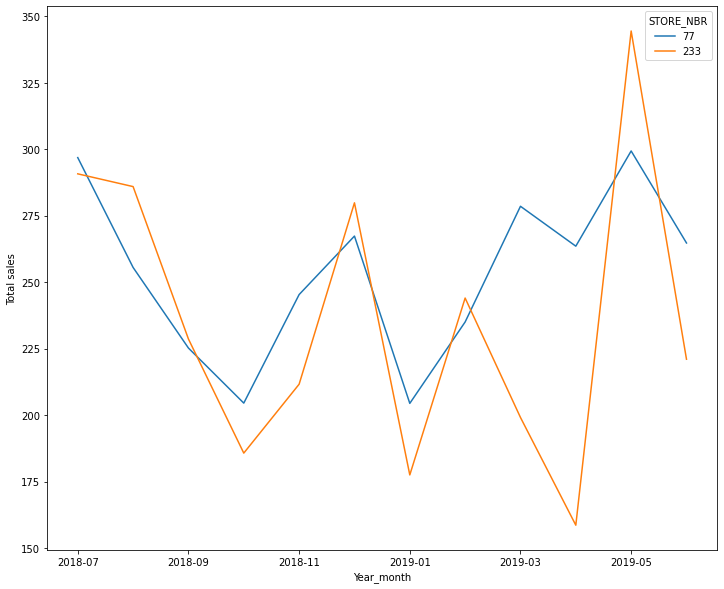

In [85]:
fig, ax = plt.subplots(figsize = (12,10))
sales_combined.loc[[77] + 
                   control_store_dict[77]].transpose().plot(
    ylabel = "Total sales", 
    ax = ax)

There seems to be a significant difference in March and April for store 77, but not in February

<AxesSubplot:xlabel='Year_month', ylabel='Total sales'>

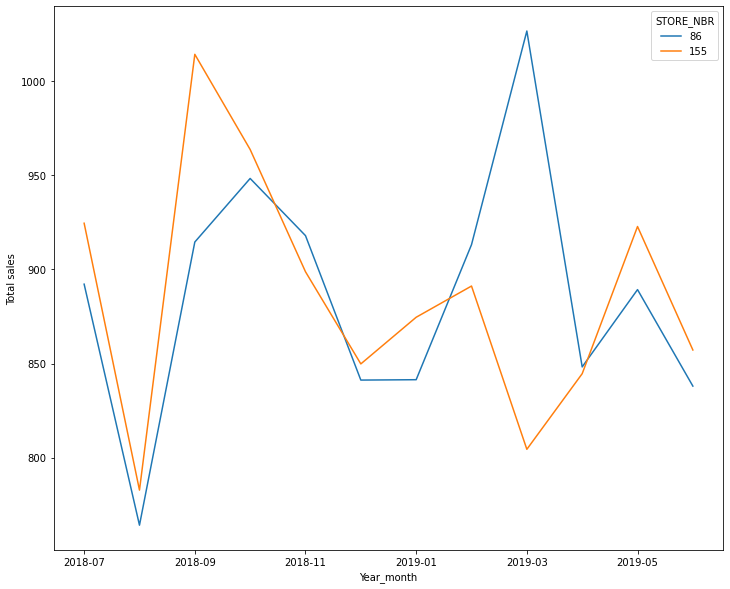

In [86]:
fig, ax = plt.subplots(figsize = (12,10))
sales_combined.loc[[86] + control_store_dict[86]].transpose().plot(
    ylabel = "Total sales", 
    ax = ax)

Significant uptick in March, but not for February or April

<AxesSubplot:xlabel='Year_month', ylabel='Total sales'>

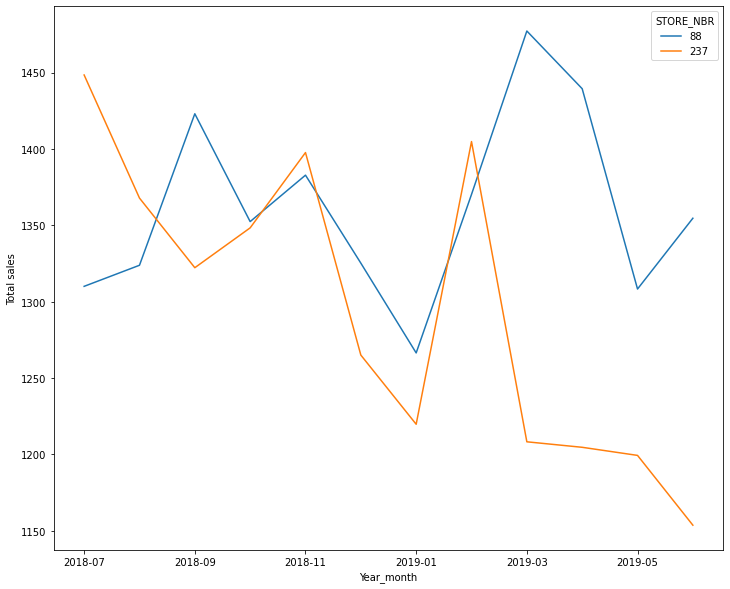

In [87]:
fig, ax = plt.subplots(figsize = (12,10))
sales_combined.loc[[88] + control_store_dict[88]].transpose().plot(
    ylabel = "Total sales", 
    ax = ax)

Massive uptick in March and April, but not February

In [88]:
pd.set_option('display.max_columns', None)
store_level_data_combined.loc[[77] + control_store_dict[77]]

level_0    Total customers                                                  \
Year_month         2018-07 2018-08 2018-09 2018-10 2018-11 2018-12 2019-01   
STORE_NBR                                                                    
77                    51.0    47.0    42.0    37.0    41.0    46.0    35.0   
233                   51.0    48.0    42.0    35.0    40.0    47.0    35.0   

level_0                                            Total sales          \
Year_month 2019-02 2019-03 2019-04 2019-05 2019-06     2018-07 2018-08   
STORE_NBR                                                                
77            45.0    50.0    47.0    55.0    41.0       296.8   255.5   
233           45.0    40.0    30.0    57.0    41.0       290.7   285.9   

level_0                                                                     \
Year_month 2018-09 2018-10 2018-11 2018-12 2019-01 2019-02 2019-03 2019-04   
STORE_NBR                                                                    
77           225.2   204.5   245.3   267.3   204.4   235.0   278.5   263.5   
233          228.6   185.7   211.6   279.8   177.5   244.0   199.1   158.6   

level_0                    Transactions per customer                      \
Year_month 2019-05 2019-06                   2018-07   2018-08   2018-09   
STORE_NBR                                                                  
77           299.3   264.7                  1.078431  1.021277  1.047619   
233          344.4   221.0                  1.058824  1.041667  1.071429   

level_0                                                               \
Year_month   2018-10   2018-11   2018-12   2019-01   2019-02 2019-03   
STORE_NBR                                                              
77          1.027027  1.073171  1.043478  1.114286  1.000000   1.100   
233         1.028571  1.025000  1.063830  1.000000  1.044444   1.025   

level_0                                  
Year_month   2019-04   2019-05  2019-06  
STORE_NBR                                
77          1.021277  1.018182  1.02439  
233         1.066667  1.087719  1.00000

Uptick for store 77 due to more total customers

In [89]:
pd.set_option('display.max_columns', None)
store_level_data_combined.loc[[86] + control_store_dict[86]]

level_0    Total customers                                                  \
Year_month         2018-07 2018-08 2018-09 2018-10 2018-11 2018-12 2019-01   
STORE_NBR                                                                    
86                    99.0    94.0   103.0   109.0   100.0    98.0    94.0   
155                  101.0    91.0   103.0   108.0   101.0    97.0    96.0   

level_0                                            Total sales          \
Year_month 2019-02 2019-03 2019-04 2019-05 2019-06     2018-07 2018-08   
STORE_NBR                                                                
86           107.0   115.0   105.0   104.0    98.0       892.2  764.05   
155           95.0    94.0    99.0   106.0    95.0       924.6  782.70   

level_0                                                                     \
Year_month 2018-09 2018-10 2018-11 2018-12 2019-01 2019-02 2019-03 2019-04   
STORE_NBR                                                                    
86           914.6   948.4   918.0   841.2   841.4   913.2  1026.8   848.2   
155         1014.4   963.8   898.8   849.8   874.6   891.2   804.4   844.6   

level_0                    Transactions per customer                      \
Year_month 2019-05 2019-06                   2018-07   2018-08   2018-09   
STORE_NBR                                                                  
86          889.30   838.0                  1.272727  1.170213  1.242718   
155         922.85   857.2                  1.217822  1.307692  1.398058   

level_0                                                                 \
Year_month   2018-10   2018-11   2018-12   2019-01   2019-02   2019-03   
STORE_NBR                                                                
86          1.266055  1.250000  1.224490  1.372340  1.289720  1.217391   
155         1.259259  1.316832  1.237113  1.302083  1.315789  1.255319   

level_0                                   
Year_month   2019-04   2019-05   2019-06  
STORE_NBR                                 
86          1.200000  1.230769  1.204082  
155         1.212121  1.283019  1.273684

Uptick for store 86 due to more total customers

In [90]:
pd.set_option('display.max_columns', None)
store_level_data_combined.loc[[88] + control_store_dict[88]]

level_0    Total customers                                                  \
Year_month         2018-07 2018-08 2018-09 2018-10 2018-11 2018-12 2019-01   
STORE_NBR                                                                    
88                   129.0   131.0   124.0   123.0   130.0   126.0   117.0   
237                  128.0   135.0   126.0   123.0   132.0   124.0   117.0   

level_0                                            Total sales          \
Year_month 2019-02 2019-03 2019-04 2019-05 2019-06     2018-07 2018-08   
STORE_NBR                                                                
88           124.0   134.0   128.0   128.0   121.0      1310.0  1323.8   
237          126.0   119.0   120.0   129.0   119.0      1448.4  1367.8   

level_0                                                                     \
Year_month 2018-09 2018-10 2018-11 2018-12 2019-01 2019-02 2019-03 2019-04   
STORE_NBR                                                                    
88          1423.0  1352.4  1382.8  1325.2  1266.4  1370.2  1477.2  1439.4   
237         1322.2  1348.3  1397.6  1265.0  1219.7  1404.8  1208.2  1204.6   

level_0                     Transactions per customer                      \
Year_month  2019-05 2019-06                   2018-07   2018-08   2018-09   
STORE_NBR                                                                   
88          1308.25  1354.6                  1.186047  1.206107  1.266129   
237         1199.30  1153.6                  1.265625  1.222222  1.182540   

level_0                                                                 \
Year_month   2018-10   2018-11   2018-12   2019-01   2019-02   2019-03   
STORE_NBR                                                                
88          1.260163  1.200000  1.174603  1.230769  1.233871  1.261194   
237         1.195122  1.219697  1.161290  1.188034  1.246032  1.126050   

level_0                                  
Year_month   2019-04   2019-05  2019-06  
STORE_NBR                                
88          1.265625  1.203125  1.22314  
237         1.125000  1.155039  1.10084

Uptick for store 88 due to more total customers for store 88 and less transactions per customer for store 237